In [1]:
import requests
import vaderSentiment
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

In [2]:
class BibleSentimentAnalyzer:
    def __init__(self):
        self.analyzer = SentimentIntensityAnalyzer()
        self.bible_data = None
        self.sentiment_results = []
        
    def download_bible_text(self):
        """Download Bible text from API"""
        print("Downloading Bible text...")
        try:
            # Using Bible API to get the complete Bible
            url = "https://bible-api.com/books"
            response = requests.get(url)
            books = response.json()
            
            bible_text = {}
            
            for book in books:
                book_name = book['name']
                book_id = book['id']
                print(f"Processing {book_name}...")
                
                # Get all chapters for this book
                book_url = f"https://bible-api.com/{book_id}"
                book_response = requests.get(book_url)
                
                if book_response.status_code == 200:
                    book_data = book_response.json()
                    bible_text[book_name] = book_data
                    
            self.bible_data = bible_text
            return True
            
        except Exception as e:
            print(f"Error downloading from API: {e}")
            print("Using alternative method...")
            return self.load_sample_bible_data()
    
    def load_sample_bible_data(self):
        """Load sample Bible data structure for demonstration"""
        # This creates a sample structure - in practice you'd load from a file or API
        sample_books = {
            "Genesis": {
                "1": "In the beginning God created the heaven and the earth. And the earth was without form, and void; and darkness was upon the face of the deep.",
                "2": "Thus the heavens and the earth were finished, and all the host of them. And on the seventh day God ended his work which he had made.",
                "3": "Now the serpent was more subtil than any beast of the field which the LORD God had made. And he said unto the woman, Yea, hath God said, Ye shall not eat of every tree of the garden?"
            },
            "Psalms": {
                "1": "Blessed is the man that walketh not in the counsel of the ungodly, nor standeth in the way of sinners, nor sitteth in the seat of the scornful.",
                "23": "The LORD is my shepherd; I shall not want. He maketh me to lie down in green pastures: he leadeth me beside the still waters.",
                "91": "He that dwelleth in the secret place of the most High shall abide under the shadow of the Almighty."
            },
            "Matthew": {
                "1": "The book of the generation of Jesus Christ, the son of David, the son of Abraham.",
                "5": "Blessed are the poor in spirit: for theirs is the kingdom of heaven. Blessed are they that mourn: for they shall be comforted.",
                "6": "Our Father which art in heaven, Hallowed be thy name. Thy kingdom come, Thy will be done in earth, as it is in heaven."
            },
            "Revelation": {
                "1": "The Revelation of Jesus Christ, which God gave unto him, to shew unto his servants things which must shortly come to pass.",
                "21": "And I saw a new heaven and a new earth: for the first heaven and the first earth were passed away; and there was no more sea.",
                "22": "And he shewed me a pure river of water of life, clear as crystal, proceeding out of the throne of God and of the Lamb."
            }
        }
        
        self.bible_data = sample_books
        print("Loaded sample Bible data for demonstration")
        return True
    
    def analyze_sentiment(self):
        """Perform sentiment analysis on all chapters"""
        print("Analyzing sentiment...")
        
        for book_name, chapters in self.bible_data.items():
            for chapter_num, text in chapters.items():
                # Get sentiment scores
                sentiment_scores = self.analyzer.polarity_scores(text)
                
                # Determine overall sentiment
                compound = sentiment_scores['compound']
                if compound >= 0.05:
                    sentiment_label = 'Positive'
                elif compound <= -0.05:
                    sentiment_label = 'Negative'
                else:
                    sentiment_label = 'Neutral'
                
                result = {
                    'book': book_name,
                    'chapter': int(chapter_num),
                    'text_length': len(text),
                    'positive': sentiment_scores['pos'],
                    'negative': sentiment_scores['neg'],
                    'neutral': sentiment_scores['neu'],
                    'compound': sentiment_scores['compound'],
                    'sentiment_label': sentiment_label,
                    'text_preview': text[:100] + '...' if len(text) > 100 else text
                }
                
                self.sentiment_results.append(result)
        
        print(f"Analyzed {len(self.sentiment_results)} chapters")
    
    def create_dataframe(self):
        """Convert results to pandas DataFrame"""
        return pd.DataFrame(self.sentiment_results)
    
    def generate_summary_statistics(self, df):
        """Generate summary statistics"""
        print("\n=== BIBLE SENTIMENT ANALYSIS SUMMARY ===")
        print(f"Total chapters analyzed: {len(df)}")
        print(f"Books analyzed: {df['book'].nunique()}")
        
        print(f"\nOverall Sentiment Distribution:")
        sentiment_counts = df['sentiment_label'].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {sentiment}: {count} chapters ({percentage:.1f}%)")
        
        print(f"\nAverage Sentiment Scores:")
        print(f"  Positive: {df['positive'].mean():.3f}")
        print(f"  Negative: {df['negative'].mean():.3f}")
        print(f"  Neutral: {df['neutral'].mean():.3f}")
        print(f"  Compound: {df['compound'].mean():.3f}")
        
        # Most positive and negative chapters
        most_positive = df.loc[df['compound'].idxmax()]
        most_negative = df.loc[df['compound'].idxmin()]
        
        print(f"\nMost Positive Chapter:")
        print(f"  {most_positive['book']} {most_positive['chapter']} (Score: {most_positive['compound']:.3f})")
        print(f"  Preview: {most_positive['text_preview']}")
        
        print(f"\nMost Negative Chapter:")
        print(f"  {most_negative['book']} {most_negative['chapter']} (Score: {most_negative['compound']:.3f})")
        print(f"  Preview: {most_negative['text_preview']}")
        
        # Book-level analysis
        print(f"\nSentiment by Book:")
        book_sentiment = df.groupby('book')['compound'].agg(['mean', 'count']).round(3)
        book_sentiment = book_sentiment.sort_values('mean', ascending=False)
        for book, row in book_sentiment.iterrows():
            print(f"  {book}: {row['mean']:+.3f} ({row['count']} chapters)")
    
    def create_visualizations(self, df):
        """Create visualizations of the sentiment analysis"""
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Bible Sentiment Analysis Results', fontsize=16, fontweight='bold')
        
        # 1. Sentiment distribution pie chart
        sentiment_counts = df['sentiment_label'].value_counts()
        colors = ['lightgreen', 'lightcoral', 'lightblue']
        axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                       autopct='%1.1f%%', colors=colors, startangle=90)
        axes[0, 0].set_title('Overall Sentiment Distribution')
        
        # 2. Compound sentiment histogram
        axes[0, 1].hist(df['compound'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 1].axvline(df['compound'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["compound"].mean():.3f}')
        axes[0, 1].set_xlabel('Compound Sentiment Score')
        axes[0, 1].set_ylabel('Number of Chapters')
        axes[0, 1].set_title('Distribution of Compound Sentiment Scores')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Book-level sentiment comparison
        book_sentiment = df.groupby('book')['compound'].mean().sort_values()
        axes[1, 0].barh(range(len(book_sentiment)), book_sentiment.values, 
                        color=['red' if x < 0 else 'green' for x in book_sentiment.values])
        axes[1, 0].set_yticks(range(len(book_sentiment)))
        axes[1, 0].set_yticklabels(book_sentiment.index)
        axes[1, 0].set_xlabel('Average Compound Sentiment Score')
        axes[1, 0].set_title('Average Sentiment by Book')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5)
        
        # 4. Sentiment components stacked bar
        sentiment_components = df.groupby('book')[['positive', 'negative', 'neutral']].mean()
        sentiment_components.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                                 color=['green', 'red', 'gray'], alpha=0.7)
        axes[1, 1].set_title('Sentiment Components by Book')
        axes[1, 1].set_xlabel('Book')
        axes[1, 1].set_ylabel('Average Score')
        axes[1, 1].legend(title='Sentiment Type')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def export_results(self, df, filename='bible_sentiment_analysis.csv'):
        """Export results to CSV file"""
        df.to_csv(filename, index=False)
        print(f"\nResults exported to {filename}")
    
    def run_complete_analysis(self):
        """Run the complete sentiment analysis pipeline"""
        print("Starting Bible Sentiment Analysis...")
        
        # Step 1: Load Bible text
        if not self.download_bible_text():
            print("Failed to load Bible text")
            return None
        
        # Step 2: Analyze sentiment
        self.analyze_sentiment()
        
        # Step 3: Create DataFrame
        df = self.create_dataframe()
        
        # Step 4: Generate summary
        self.generate_summary_statistics(df)
        
        # Step 5: Create visualizations
        self.create_visualizations(df)
        
        # Step 6: Export results
        self.export_results(df)
        
        return df

Starting Bible Sentiment Analysis...
Error downloading from API: string indices must be integers
Using alternative method...
Loaded sample Bible data for demonstration
Analyzing sentiment...
Analyzed 12 chapters

=== BIBLE SENTIMENT ANALYSIS SUMMARY ===
Total chapters analyzed: 12
Books analyzed: 4

Overall Sentiment Distribution:
  Positive: 9 chapters (75.0%)
  Neutral: 2 chapters (16.7%)
  Negative: 1 chapters (8.3%)

Average Sentiment Scores:
  Positive: 0.143
  Negative: 0.035
  Neutral: 0.822
  Compound: 0.424

Most Positive Chapter:
  Matthew 5 (Score: 0.866)
  Preview: Blessed are the poor in spirit: for theirs is the kingdom of heaven. Blessed are they that mourn: fo...

Most Negative Chapter:
  Psalms 23 (Score: -0.057)
  Preview: The LORD is my shepherd; I shall not want. He maketh me to lie down in green pastures: he leadeth me...

Sentiment by Book:
  Genesis: +0.580 (3.0 chapters)
  Matthew: +0.544 (3.0 chapters)
  Revelation: +0.502 (3.0 chapters)
  Psalms: +0.072 (3.0 c

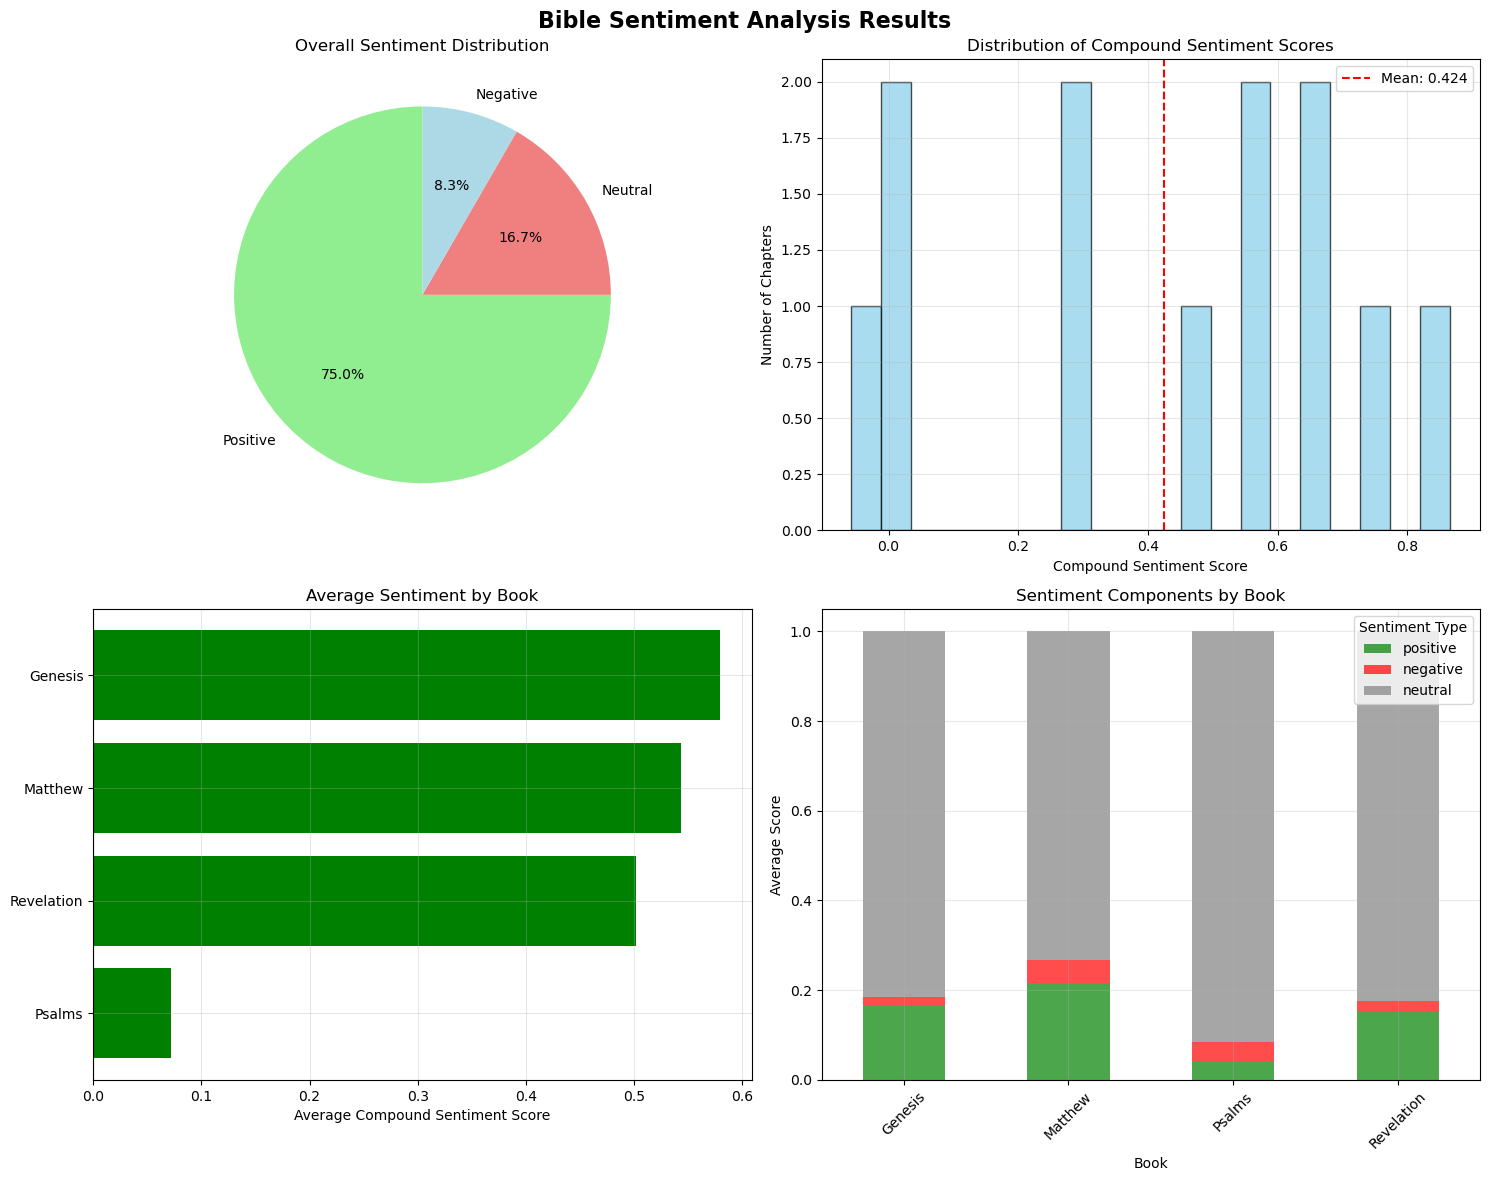


Results exported to bible_sentiment_analysis.csv

=== ADDITIONAL INSIGHTS ===

Top 5 Most Positive Chapters:
  Matthew 5: +0.866
  Matthew 6: +0.765
  Genesis 1: +0.660
  Revelation 21: +0.660
  Genesis 2: +0.586

Top 5 Most Negative Chapters:
  Psalms 23: -0.057
  Psalms 91: +0.000
  Matthew 1: +0.000
  Psalms 1: +0.273
  Revelation 1: +0.273

Correlation between text length and sentiment: 0.387


In [3]:
# Usage example
if __name__ == "__main__":
    # Install required packages first:
    # pip install vaderSentiment pandas matplotlib seaborn requests
    
    analyzer = BibleSentimentAnalyzer()
    results_df = analyzer.run_complete_analysis()
    
    # Additional analysis examples
    if results_df is not None:
        print("\n=== ADDITIONAL INSIGHTS ===")
        
        # Find chapters with extreme sentiments
        print("\nTop 5 Most Positive Chapters:")
        top_positive = results_df.nlargest(5, 'compound')[['book', 'chapter', 'compound']]
        for _, row in top_positive.iterrows():
            print(f"  {row['book']} {row['chapter']}: {row['compound']:+.3f}")
        
        print("\nTop 5 Most Negative Chapters:")
        top_negative = results_df.nsmallest(5, 'compound')[['book', 'chapter', 'compound']]
        for _, row in top_negative.iterrows():
            print(f"  {row['book']} {row['chapter']}: {row['compound']:+.3f}")
        
        # Correlation analysis
        print(f"\nCorrelation between text length and sentiment: {results_df['text_length'].corr(results_df['compound']):.3f}")
